---
>>>>> # **Fusion of algorithms for face recognition**

---
###Realised By : Khalil Bouguerra 
---


####For a full version of the report and  better graphics visulisation please open this notebook in [google colab environment [Fusion of algorithms for face recognition](https://colab.research.google.com/drive/1obJMHbaiCY82qiV152AzK2OQ4V3ee3ah?usp=sharing)
---



# Introduction 


The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps.

*  1st, a vector of features is computed for each image.
*  2nd, a simple function produces a vector of scores for a pair of images. 

$\implies$ The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

# Work OverFlow : 

## Imports 

In [ ]:
import pandas as pd 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pprint import pprint as Print
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
import  lightgbm as lgb
import time
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
from scipy.stats import randint 
from scipy.stats import uniform 
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, f_classif

verbose=False 
max_coef=3
CM=False 

Bare_model_scores={}
tuned_model_scores={}
Meta_model_scores={}


##Importing Data 


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1K30Xd4z_hF77f7htkHZwIwkqohTwpfli',dest_path='./data/xtrain_challenge.csv')
gdd.download_file_from_google_drive(file_id='1DbpcvlOxDMk64acnQZcJLAmGm-Gu7M8e',dest_path='./data/ytrain_challenge.csv')
gdd.download_file_from_google_drive(file_id='17claJ2kZxXBJ8NjydXTJtdYPiYbmO7Tt',dest_path='./data/xtest_challenge.csv')
df = pd.read_csv('./data/xtrain_challenge.csv')
df['y']= pd.read_csv('./data/ytrain_challenge.csv')['y']
Test=pd.read_csv('./data/xtest_challenge.csv')


##Data Spliting & Scalling 

### Splitting the data: 

* Training data:  This is the data used to train the model, to fit the model parameters. It will account for the largest proportion of data as we wish for the model to see as many examples as possible.

* Test data :This is the data used to evaluate and compare models. As this data has not been seen during training nor tuning, it can provide insight into whether your models generalize well to unseen data.

### Scalling

* Scalling or Standardization  of the data : 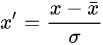 Where  $x$  is the original feature vector, $\bar x$ is the mean of that feature vector, and $\sigma$ is its standard deviation. 

* Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. 
In our case , many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

* Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it.


### Whole Data Set

In [ ]:
X_base=df.drop('y',axis=1)
y_base=df['y']
#spliting the whole dataset:  into 67% for training and 33% for testing( validation)
X_base_train , X_base_test, y_base_train, y_base_test= train_test_split(X_base, y_base, test_size=0.33,random_state =666)
#Scaling the whole dataset and the Testing dataset: 
scaler=StandardScaler() 
scaler.fit(X_base_train)
X_base_train=pd.DataFrame(scaler.transform(X_base_train),columns=X_base_train.columns)
X_base_test=pd.DataFrame(scaler.transform(X_base_test),columns=X_base_test.columns)
Test_scaled=pd.DataFrame(scaler.transform(Test),columns=Test.columns)

### SubSample from data set 

$\implies$We need this subsample of the data to tune our models in order to determine the right values for the hyperparamters.
Knowing that tunning the model consisted in fitting the models multiple times using different combinations of hyperparamters values. 
This step is computationally consuming, especially when the train dataset is this large. So we decided to use a sub-sample of the training data to use it as a representative sample of our data during the tuning phase in order to make the computations less time consuming (around 10hours for some algorithms running just on 10% of the data)

In [ ]:
#We will run our models tunning on 10% training 10% testing (for computational reasons) 
y=np.array(y_base)
sss = StratifiedShuffleSplit( n_splits=1, test_size=0.8, random_state=666)

## The diffrence between StratifiedShuffleSplit and train_test_split 
## is that train_test_split splits the data randomly without taking in consideration
## the proprtion of each class in each item of the split.
## We can make sure the classes proportions is split evenly if we use StratifiedShuffleSplit

for split_1,split_2 in sss.split(np.zeros(len(y)),y):
  X_tunning=X_base.iloc[split_1] #20% of  X_train  
  y_tunning=y_base[split_1] #20% of y_train

## even for tunning we need train (tunning) set and test set for tunned models selection
## that is why we split the tunning data into  train and test sets evenly 
## which result in 10% of the whole training data for each of tunnig train and test sets 

X_tunning_train,X_tunning_test,y_tunning_train,y_tunning_test=train_test_split(X_tunning,y_tunning,test_size=0.5,random_state=666) #10% of data for tunning_train & 10% of data for  tunning_test 

#Scalling 
scaler=StandardScaler() 
scaler.fit(X_tunning_train)
X_tunning_train=pd.DataFrame(scaler.transform(X_tunning_train),columns=X_tunning_train.columns)
X_tunning_test=pd.DataFrame(scaler.transform(X_tunning_test),columns=X_tunning_test.columns)
  

##Exploratary Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068504 entries, 0 to 1068503
Data columns (total 38 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   qs1     1068504 non-null  float64
 1   qs2     1068504 non-null  float64
 2   qs3     1068504 non-null  float64
 3   qs4     1068504 non-null  float64
 4   qs5     1068504 non-null  float64
 5   qs6     1068504 non-null  float64
 6   qs7     1068504 non-null  float64
 7   qs8     1068504 non-null  float64
 8   qs9     1068504 non-null  float64
 9   qs10    1068504 non-null  float64
 10  qs11    1068504 non-null  float64
 11  qs12    1068504 non-null  float64
 12  qs13    1068504 non-null  float64
 13  qr1     1068504 non-null  float64
 14  qr2     1068504 non-null  float64
 15  qr3     1068504 non-null  float64
 16  qr4     1068504 non-null  float64
 17  qr5     1068504 non-null  float64
 18  qr6     1068504 non-null  float64
 19  qr7     1068504 non-null  float64
 20  qr8     1068504 non-null

###NA Values
In real life dataset we usually end up with some missing values (aka NA, None, NaN,.. values)

Some algorithms can't deal with such data type (NA) or it  affects its performances. So we should locate these values and either drop the row, which may cause  a lot of information loss or change it to some other value depending on the case (null value, mean value, .. )

In [ ]:
df.isna().sum(axis=0)
## We don't have to worry  about NA values!

qs1     0
qs2     0
qs3     0
qs4     0
qs5     0
qs6     0
qs7     0
qs8     0
qs9     0
qs10    0
qs11    0
qs12    0
qs13    0
qr1     0
qr2     0
qr3     0
qr4     0
qr5     0
qr6     0
qr7     0
qr8     0
qr9     0
qr10    0
qr11    0
qr12    0
qr13    0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
s7      0
s8      0
s9      0
s10     0
s11     0
y       0
dtype: int64

###Duplicated data
* Duplicated values if present with high occurence in our dataset can affect the performance of the models. 
* So we better check for duplicated values and eliminate them if found.

In [ ]:
df[df.duplicated(keep="first")].count() 
## We don't have to worry about duplicated rows in our dataset. 

qs1     0
qs2     0
qs3     0
qs4     0
qs5     0
qs6     0
qs7     0
qs8     0
qs9     0
qs10    0
qs11    0
qs12    0
qs13    0
qr1     0
qr2     0
qr3     0
qr4     0
qr5     0
qr6     0
qr7     0
qr8     0
qr9     0
qr10    0
qr11    0
qr12    0
qr13    0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
s7      0
s8      0
s9      0
s10     0
s11     0
y       0
dtype: int64

### Outliers:



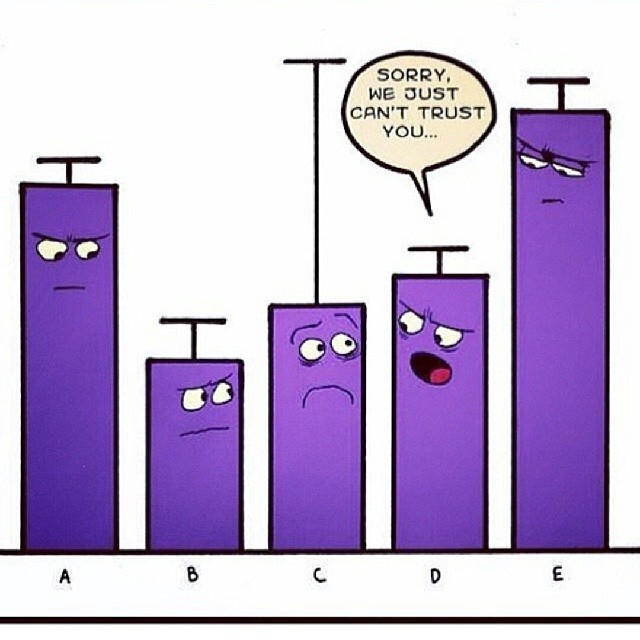

####Outliers Elmination

Number of observations to be dropped if we use outliers elimination:  30894
Number of observations in positive class before dropping outliers: 0.03705461093266848
Number of observations in positive class after  dropping outliers: 0.02568402386253024


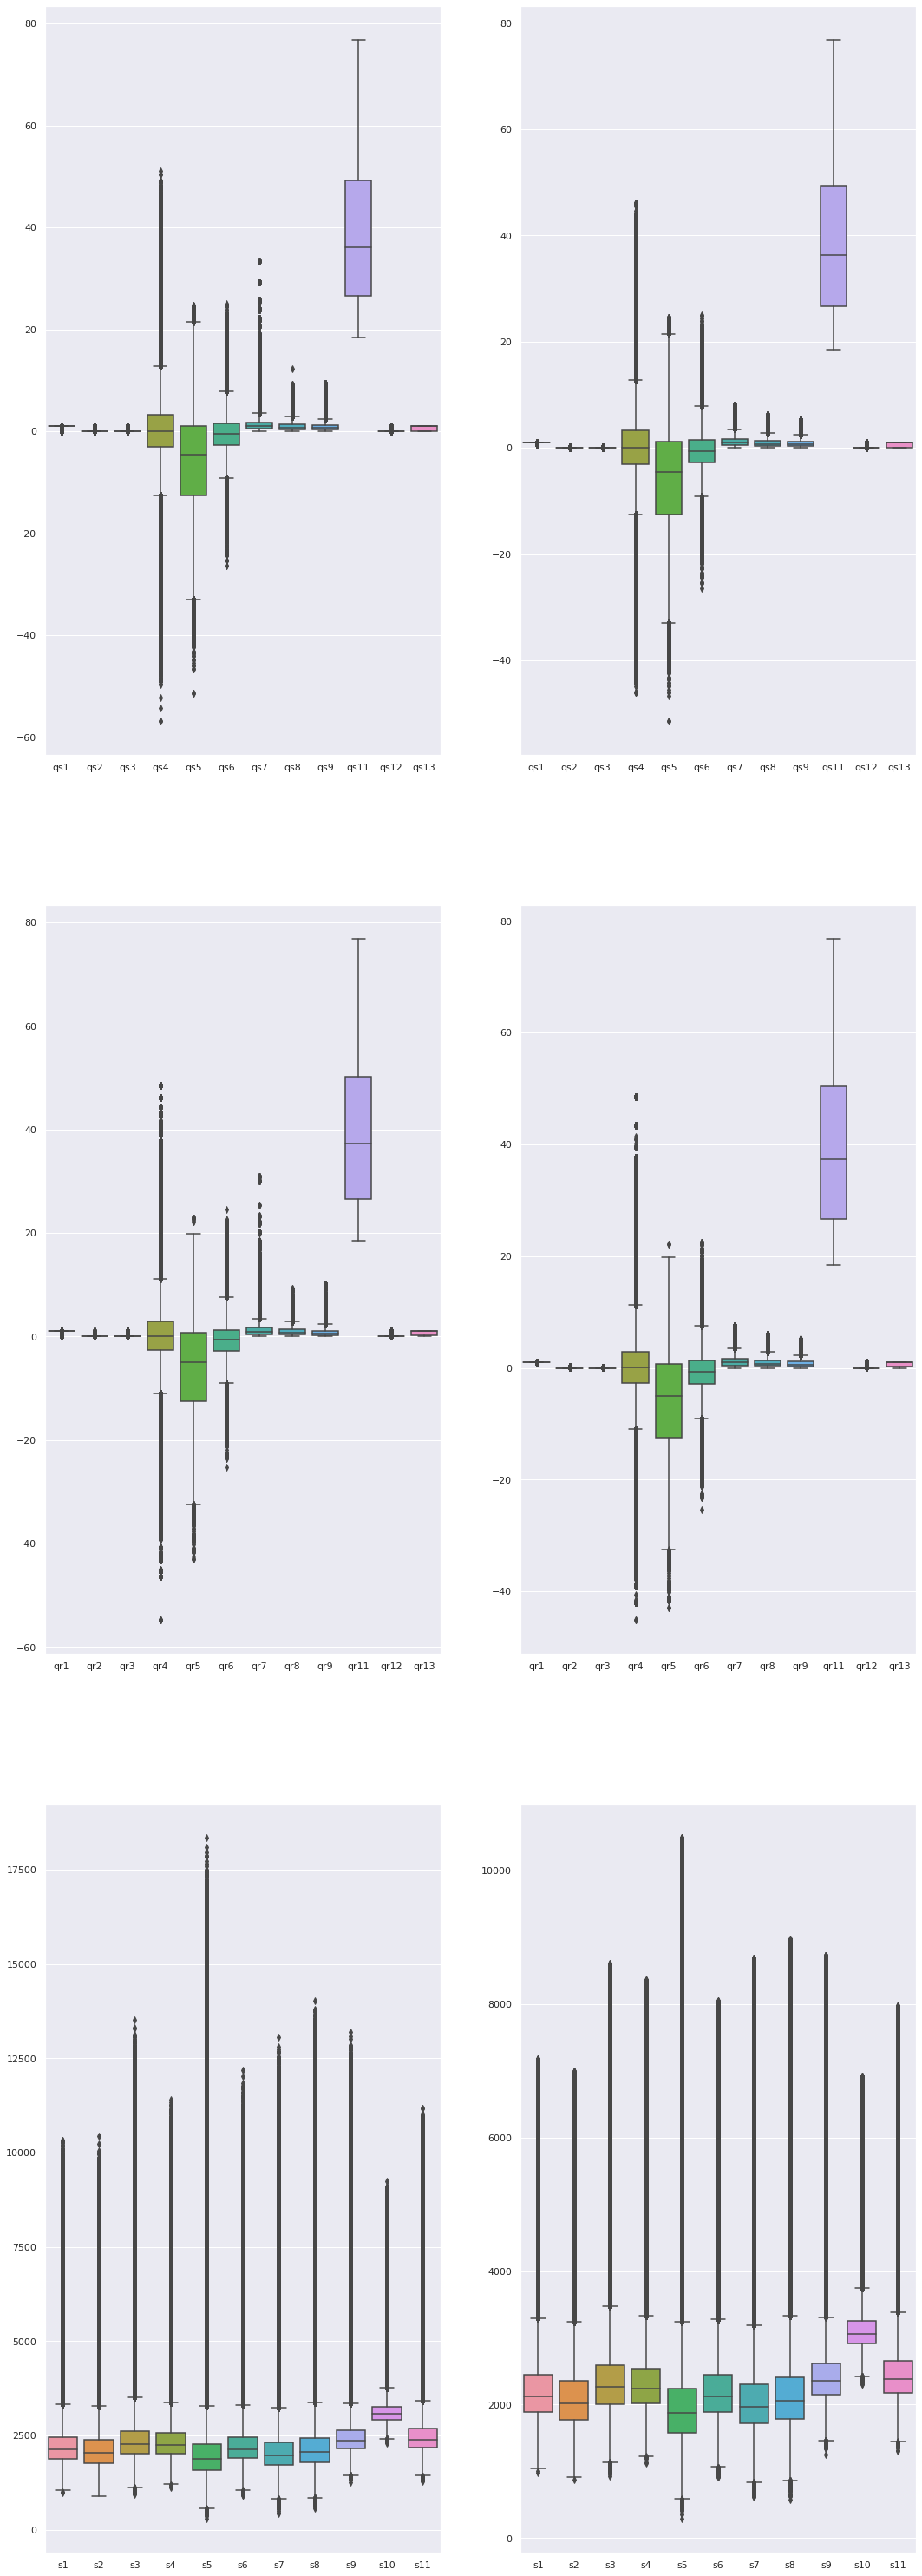

In [ ]:
##Original Data 
img1=df[df.columns[:13]].drop(['qs10'],axis=1) ##we didnt use qs10 because with such large values we can't see outlires in boxplot 
img2=df[df.columns[13:26]].drop(['qr10'],axis=1)  ##we didnt use qr10 because with such large values we can't see outlires in  boxplot 
score=df[df.columns[26:-1]]

## Data after Eliminating outliers: 

df_2= df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 

## Removing outlires(we consider values  very far from the mean as outliers aka having a large Zscore )
## This just trims any observations with values four standard deviations from the mean or more (either positive or negative since we are taking the absolute value).
## => we should check if this makes the results  any better later on.

img1_2=df_2[df_2.columns[:13]].drop(['qs10'],axis=1)  
img2_2=df_2[df_2.columns[13:26]].drop(['qr10'],axis=1) 
score_2=df_2[df_2.columns[26:-1]]
print("Number of observations to be dropped if we use outliers elimination: ", df.count()['y']-df_2.count()['y']) 
print("Number of observations in positive class before dropping outliers:", df[df['y']==1].count()['y']/df['y'].count())
print("Number of observations in positive class after  dropping outliers:",df_2[df_2['y']==1].count()['y']/df_2['y'].count())

#First, I want to go ahead and check for outliers. I’ll use a Seaborn boxplot for this,

sns.set(rc={'figure.figsize':(18,54)})
fig, axs = plt.subplots(ncols=2,nrows=3)
sns.boxplot(data=img1,ax=axs[0][0])
sns.boxplot(data=img1_2,ax=axs[0][1])
sns.boxplot(data=img2,ax=axs[1][0])
sns.boxplot(data=img2_2,ax=axs[1][1])
sns.boxplot(data=score,ax=axs[2][0])
sns.boxplot(data=score_2,ax=axs[2][1])


####Outliers effect  using a simple model as a baseline : 

In [ ]:
def logReg(X_train , y_train, X_test , y_test, **kwargs): 
  logreg=LogisticRegression(**kwargs)
  logreg.fit(X_train, y_train)
  ranked_coef=list(zip(X_train.columns,logreg.coef_[0]))
  ranked_coef.sort(key=lambda x:-x[1])
  Print(ranked_coef[:3])
  y_pred=logreg.predict(X_test)
  print("="*20)
  print("Classification Accuracy: ",accuracy_score(y_test,y_pred))
  print("F1 score: ",f1_score(y_test,y_pred))
  print("="*20)
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("="*20)
  return logreg




In [ ]:
##Testing the performance of a baseline model after droping outliers 

X_outlier=df_2.drop('y',axis=1)
y_outlier=df_2['y']
X_outlier_train , X_outlier_test, y_outlier_train, y_outlier_test= train_test_split(X_outlier, y_outlier, test_size=0.33,random_state =666)

scaler=StandardScaler() 
scaler.fit(X_outlier_train)
X_outlier_train_scaled=pd.DataFrame(scaler.transform(X_outlier_train),columns=X_outlier_train.columns)
X_outlier_test_scaled=pd.DataFrame(scaler.transform(X_outlier_test),columns=X_outlier_test.columns)
x=logReg(X_outlier_train_scaled, y_outlier_train,X_outlier_test_scaled,y_outlier_test,max_iter=2000)


[('s5', 1.6360795781397088),
 ('s4', 1.1514490523914094),
 ('s9', 1.1340366947616451)]
Classification Accuracy:  0.9982594067964907
F1 score:  0.9654732939404471
Confusion Matrix:
[[333483    206]
 [   390   8333]]


In [ ]:
##Testing the performance of a baseline model after droping outliers 
X_base=df.drop('y',axis=1)
y_base=df['y']
X_base_train , X_base_test, y_base_train, y_base_test= train_test_split(X_base, y_base, test_size=0.33,random_state =666)
scaler=StandardScaler() 
scaler.fit(X_base_train)
X_base_train_scaled=pd.DataFrame(scaler.transform(X_base_train),columns=X_base_train.columns)
X_base_test_scaled=pd.DataFrame(scaler.transform(X_base_test),columns=X_base_test.columns)
Test_scaled=pd.DataFrame(scaler.transform(Test),columns=Test.columns)
x=logreg=logReg(X_base_train_scaled, y_base_train,X_base_test_scaled,y_base_test,max_iter=2000)


[('s5', 2.200376840079408),
 ('s9', 1.601991146321581),
 ('s4', 1.502850492514285)]
Classification Accuracy:  0.9981338997807757
F1 score:  0.9744068455853753
Confusion Matrix:
[[339423    236]
 [   422  12526]]


$\implies$ As you can see in the boxplots we managed to eliminate outliers from our data, but it turns out that what we qualified as outliers are actually the positive class observation and we can see that after we eliminate what we previously considered as outliers we lost most of the positive class observations (using Z score threshold = 6) and all of them (using score threshold= 8 )

$\implies$ Using Zscore threshold = 6 as a criteria to remove outliers actually improved  our baseline model performance (slight increase in accuracy and F1 score plus  the confusion matrix proves that we have less wrong classification ). 

 $\implies$ This may seems as a good thing since we improved the performance , But actually NO , because the improvement is due to the fact that we have less data in the postive class  ( one way to see it is that we removed the obeservation that are hard to classify , because they are far from the mean data => Thus improving the metrics and not the  performance of the model ) 

$\implies$ Thus we won't be eliminating those observations , since it will make our data useless without a positive class.

####Corrolation Analysis 


Let's check corolation  between our target feature and  our independent variables. 


In [ ]:
def heatmap(df): 
  corr=df.corr()
  fig,ax=plt.subplots(figsize=(30,30))
  mask=np.zeros_like(corr,dtype=np.bool)
  color_map=sns.color_palette("hot_r")
  ax=sns.heatmap(corr,cmap=color_map,mask=mask,annot=True)
  most_corr_features=corr['y'].drop('y')
  return most_corr_features.nlargest(10)

s9     0.846801
s4     0.839741
s11    0.838700
s10    0.836195
s5     0.832402
s7     0.824881
s8     0.809865
s6     0.790947
s3     0.786453
s1     0.764015
Name: y, dtype: float64


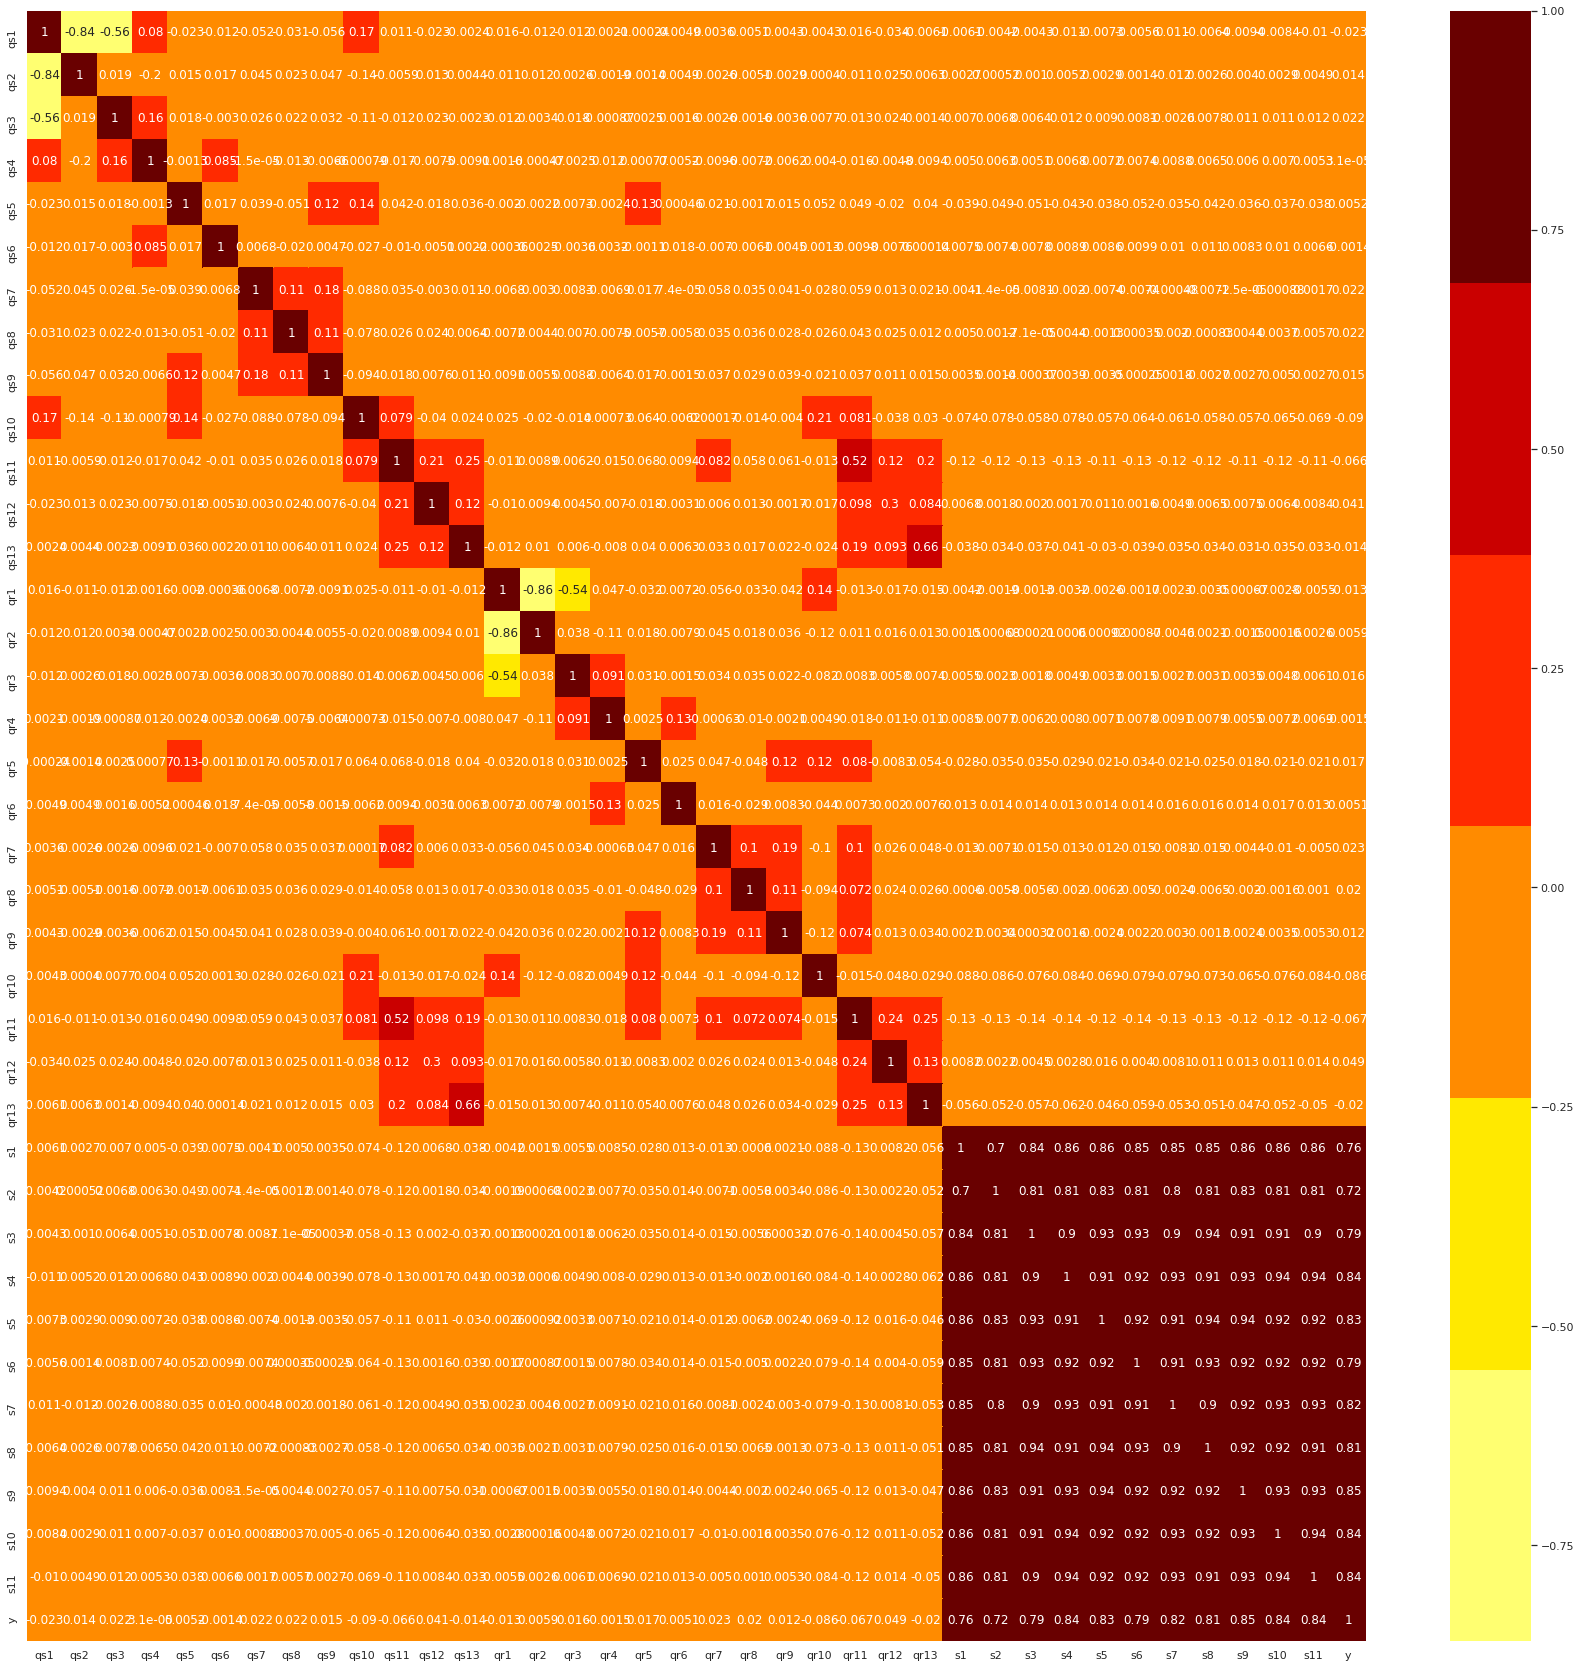

In [ ]:
most_corr_features= heatmap(df)
print(most_corr_features)

$\implies$ It looks like our target variable has a mostly weak correlation, with the exception of the scores features  that are  the most corrolated features with the target varible,
and this explains why with a simple LogReg we found the most inmportant features are {s5,s9,s4} , because they are the most corrolated ones with the target variable.


###Unbalanced/Balanced Data:  


Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. Let's check if we have this problem of class imbalance.
 


In [ ]:

class_0_count=df[df['y']==0].count()['y']
class_1_count=df[df['y']==1].count()['y']
all_data_count=df.count()['y']
class_1_ratio= class_1_count/all_data_count
class_0_ratio= class_0_count/all_data_count
print(class_1_ratio,class_0_ratio)
fig = go.Figure()
fig.add_trace(go.Pie( values=[class_1_ratio,class_0_ratio], labels=["Postive Class","Negative Class"]))
fig.update_layout(title="Proportions of Classes among the whole  Data",

    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ))
fig.show()


0.03705461093266848 0.9629453890673315


$\implies$ We have  a disproportionate ratio of observations in each class (3.7% vs 96.3%).

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error. 

So this kind of data distrubution can cause some problems later on like : 

  * The model predicting always The major class 

  * The Performance won't be as expected because we don't have enough data in Positive class.
 

Solutions: 

  * Resampling Techniques — Oversample minority class:
  
  Oversampling can be defined as adding more copies of the minority class.
    * Pros: Oversampling can be a good choice when you don’t have a ton of data to work with.
    * Cons: The computation Cost increases with the data increasing.
  * Resampling techniques — Undersample majority class: 
  Undersampling can be defined as removing some observations of the majority class. 
    * Pros: Undersampling can be a good choice when we have a ton of data.
    * Cons: Removing information that may be valuable  could lead to underfitting and poor generalization to the test set.

$\implies$ we will use oversimpling the data  in order to compensate for the data unbalance without losing what could be valuable information.
  


In [ ]:

# concatenate our training data back together
X = pd.concat([X_base_train, y_base_train], axis=1)

# separate minority and majority classes
Pos_class = X[X['y']==1]
Neg_class = X[X['y']==0]

ratio=4
# upsample minority
Pos_upsampled = resample(Pos_class,
                          replace=True, # sample with replacement
                          n_samples=ratio*len(Pos_class), # we can't resample the data alot (like len(Neg_class))
                                                      # because the data will be redendent alot and that may 
                                                      # effect out results later on. Exprementing some values for ratio 
                                                      # we found out that 4 gives the good results. 
                          random_state=666) 

# combine majority and upsampled minority
upsampled = pd.concat([Neg_class,Pos_upsampled])

X_base_train=upsampled.drop('y',axis=1)
y_base_train = upsampled['y']

print(upsampled[upsampled['y']==1].count()['y'])



class_0_count=upsampled[upsampled['y']==0].count()['y']
class_1_count=upsampled[upsampled['y']==1].count()['y']
all_data_count=upsampled.count()['y']
class_1_ratio= class_1_count/all_data_count
class_0_ratio= class_0_count/all_data_count
print(class_1_ratio,class_0_ratio)
fig = go.Figure()
fig.add_trace(go.Pie( values=[class_1_ratio,class_0_ratio], labels=["Postive Class","Negative Class"]))
fig.update_layout(title="Proportions of Classes among the Train Data",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ))
fig.show()


106580
0.13392273746217795 0.866077262537822


##Implementation

###Model serialization 

In [ ]:
#SAVING Models,Variables,parameters  on hard disk 
def save_model(model,model_name,acc): 
  path=PATH+model_name+"-"+str(acc)+".mod"
  pickle.dump(model, open(path, 'wb')) 
def save_param(param,model_name,acc): 
  path=PATH+model_name+"-"+str(acc)+".prm"
  pickle.dump(param, open(path, 'wb')) 
def save_feat(feat,model_name): 
  path=PATH+model_name+".ft"
  pickle.dump(feat, open(path, 'wb'))
#LOADING Models,Variables,parameters on hard sisk 
def load(name): 
  return pickle.load(open(PATH+name, 'rb'))

### Metrics 

In [ ]:
def scores(y_test,y_pred):
  acc=accuracy_score(y_test,y_pred)
  precision=precision_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  if(verbose):
    print("="*40)
    print("Classification Accuraccy: ",format(acc,'.10f'))
    print("precision score : ",format(precision,'.10f'))
    print("recall score: ",format(recall,'.10f'))
    print("f1 score: ",format(f1,'.10f'))
    print("="*40)
  return [acc,precision,recall,f1]


### Baseline Models: 

#### LogisticRegression 


In [ ]:
def logReg(X_train, y_train, X_test, y_test,**kwargs):
    logreg = LogisticRegression(max_iter=2000,**kwargs)
    logreg.fit(X_train, y_train)
    if(verbose): 
      ranked_coef=list(zip(X_train.columns,logreg.coef_[0]))
      ranked_coef.sort(key=lambda x:-x[1])
      Print(ranked_coef[:max_coef])  
    y_pred = logreg.predict(X_test)
    Bare_model_scores['logreg']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(logreg,X_train,y_train,cmap='Blues')
    return logreg

####RidgeClassifier 

In [ ]:
def ridge(X_train, y_train, X_test, y_test,**kwargs):
    ridgeclassifier = RidgeClassifier(**kwargs)
    ridgeclassifier.fit(X_train, y_train)
    if(verbose): 
      ranked_coef=list(zip(X_train.columns,ridgeclassifier.coef_[0]))
      ranked_coef.sort(key=lambda x:-x[1])
      Print(ranked_coef[:max_coef]) 
    y_pred = ridgeclassifier.predict(X_test)
    Bare_model_scores['ridge']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(ridgeclassifier,X_train,y_train,cmap='Blues')
    return ridgeclassifier

####SVM

In [ ]:
def svm(X_train, y_train, X_test, y_test, **kwargs):
    svm = SVC(**kwargs)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    Bare_model_scores['svm']=scores(y_test, y_pred)
    if(CM):
      plot_confusion_matrix(svm,X_train,y_train,cmap='Blues')
    return svm

####K-Nearest Neighbors

In [ ]:
def knn(X_train, y_train, X_test, y_test,**kwargs):
    Knn = KNeighborsClassifier(**kwargs)
    Knn.fit(X_train, y_train)
    y_pred = Knn.predict(X_test)
    Bare_model_scores['knn']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(Knn,X_train,y_train,cmap='Blues')
    return Knn

####BaggingClassifier

In [ ]:
def bagging(X_train, y_train, X_test, y_test,**kwargs):
    Bagging = BaggingClassifier( **kwargs) 
    Bagging.fit(X_train,y_train)
    y_pred = Bagging.predict(X_test)
    Bare_model_scores['bagging']=scores(y_test, y_pred)
    if(CM):
      plot_confusion_matrix(Bagging,X_train,y_train,cmap='Blues')
    return Bagging

####RandomForest


In [ ]:
def randomForest(X_train, y_train, X_test, y_test,**kwargs):
    rf = RandomForestClassifier(**kwargs) 
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    Bare_model_scores['randomForest']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(rf,X_train,y_train,cmap='Blues')
    return rf

####XGBoost

In [ ]:
def xgboost(X_train, y_train, X_test, y_test,**kwargs):
    xg = xgb.XGBClassifier(**kwargs)
    xg.fit(X_train,y_train)
    y_pred = xg.predict(X_test)
    Bare_model_scores['xgboost']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(xg,X_train,y_train,cmap='Blues')
    return xg

####LightGBM

In [ ]:
def lgbm(X_train, y_train, X_test, y_test,**kwargs):
    lgbm = lgb.LGBMClassifier(**kwargs)
    lgbm.fit(X_train,y_train)
    y_pred = np.rint(lgbm.predict(X_test))
    Bare_model_scores['lgbm']=scores(y_test, y_pred)
    if(CM): 
      plot_confusion_matrix(lgbm,X_train,y_train,cmap='Blues')
    return lgbm



#### Performances of the baseline models: 

In [ ]:
Models={"logreg":logReg,"ridge":ridge,"svm":svm,"knn":knn,"bagging":bagging,"randomForest":randomForest,"xgboost":xgboost,"lgbm":lgbm}

start_time = time.time()

for model in Models: 

  trained_model=Models[model](X_base_train, y_base_train,X_base_test,y_base_test)
  save_model(trained_model,model,Bare_model_scores[model][0])
  print("---Training :  %s s ---" % (time.time() - start_time))
  start_time=time.time()
  


===== Model:logreg ========
---Training :  293.8022964000702 s ---
===== Model:ridge ========
---Training :  1.223541021347046 s ---
===== Model:svm ========
---Training :  462.3825237751007 s ---
===== Model:knn ========
---Training :  1572.4250235557556 s ---
===== Model:bagging ========
---Training :  680.9955291748047 s ---


===== Model:randomForest ========
---Training :  1043.4162375926971 s ---
===== Model:xgboost ========
---Training :  141.03545260429382 s ---
===== Model:lgbm ========
---Training :  19.371358633041382 s ---


In [ ]:
Models=["lgbm","logreg","ridge","svm","knn","bagging","randomForest","xgboost"]

models=[i for i in Bare_model_scores ]
acc=[Bare_model_scores[i][0] for i in Bare_model_scores ]
f1=[Bare_model_scores[i][-1]for i in Bare_model_scores ]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=models,
    y=acc,
    name='Accuracy',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=models,
    y=f1,
    name='F1',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', yaxis=dict(range=[0.9, 1 ]),xaxis_tickangle=-45,title="Accuracy & F1 Score ",
    xaxis_title="Algorithms",
    yaxis_title="Scores",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ))
fig.show()


$\implies$  Based on the graph above , the best base models are LightGBM and XGBoost followed by  randomForest. That is why in the rest of this notebook we will focus on those models  

### Features Selection: 

* Feature Selection hugely impacts the performance of model, espacialy if  not all th data is relevent. Irrelevant or partially relevant features can negatively impact model performance.
* Feature Selection is the process where we automatically or manually select those features which contribute most to our prediction variable or output in which we are interested in.


##### Correlation: 

* Correlation states how the features are related to each other or the target variable.
* Using the heatmap plotted above, we can say that the most relevant features are the score features. 
* After some experimenting we figured that, although the output variable is mostly correlated with score features, trying baseline models over those features only, did in fact reduce computation time, but yet decreased the model's performance. 
 
 $\implies$ We will use Feature ranking with recursive feature elimination and cross-validated selection function implemented in most tree based algorithms of sklearn or those algorithms who provide a feature importance score in order to do feature selection and reduce our data space

##### Feature ranking with recursive feature elimination and cross-validated selection: 

* *Recursive* feature elimination is based on the idea to repeatedly construct a model  and choose the worst performing feature ( based on features importance coefficients), setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, finding the best performing subset of features.

In [ ]:
def rfe_cv(estimator,step,cv,scoring,X_train,y_train):
    selector = RFECV(estimator=estimator, step=step, cv=cv, scoring=scoring,verbose=3)
    selector.fit(X_train,y_train)
    selected_columns = X_train.columns[selector.support_]
    removed_columns = X_train.columns[~selector.support_]
    print('*'*20+'SELECTED'+'*'*19)
    Print(list(selected_columns))
    return [selected_columns,selector.grid_scores_]

    

######XGBoost Feature-Selection 


In [ ]:
xg_final = xgb.XGBClassifier()
xg_selector,grid = rfe_cv(xg_final,1,2,'accuracy', X_tunning_train, y_tunning_train) 
save_feat(xg_selector,"XGBoost") 

X_xg = df[xg_selector]
y_xg = df['y']

Test_xg=Test[xg_selector]

X_xg_train, X_xg_test, y_xg_train, y_xg_test = train_test_split(X_xg, y_xg)
xg_scaler = StandardScaler()  
xg_scaler.fit(X_xg_train)
X_xg_train_scaled = pd.DataFrame(xg_scaler.transform(X_xg_train), columns=X_xg_train.columns) 
X_xg_test_scaled = pd.DataFrame(xg_scaler.transform(X_xg_test), columns=X_xg_test.columns)
Test_xg_selected=pd.DataFrame(xg_scaler.transform(Test_xg), columns=Test_xg.columns)
xg_final_selected=xgboost(X_xg_train_scaled,y_xg_train,X_xg_test_scaled,y_xg_test)

verbose=False 

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

######LightGBM Feature-Selection 


In [ ]:
lgbm_final = lgb.LGBMClassifier()
lgbm_selector,grid_lgbm = rfe_cv(lgbm_final,1,2,'accuracy', X_tunning_train, y_tunning_train) 
save_feat(lgbm_selector,"lgbm") 

X_xg = df[lgbm_selector]
y_xg = df['y']

Test_xg=Test[lgbm_selector]

X_xg_train, X_xg_test, y_xg_train, y_xg_test = train_test_split(X_xg, y_xg)
xg_scaler = StandardScaler()  
xg_scaler.fit(X_xg_train)
X_xg_train_scaled = pd.DataFrame(xg_scaler.transform(X_xg_train), columns=X_xg_train.columns) 
X_xg_test_scaled = pd.DataFrame(xg_scaler.transform(X_xg_test), columns=X_xg_test.columns)
Test_xg_selected=pd.DataFrame(xg_scaler.transform(Test_xg), columns=Test_xg.columns)
lgbm_final_selected=lgbm(X_xg_train_scaled,y_xg_train,X_xg_test_scaled,y_xg_test)

verbose=False 



Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

###### Feature importance results: 

In [ ]:
feature_importance=[[grid_lgbm[i],grid[i],X_base_train.columns[i]] for i in range(len(X_base_train.columns))]
feature_importance.sort()
feature_names=[i[2]for i in feature_importance]
importance_lgbm=[i[0]-0.9 for i in feature_importance]
importance_xgb=[i[1]-0.9 for i in feature_importance]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=feature_names,
    y=importance_lgbm,
    name='LGBM Feature Importance ',
    marker_color='LightSkyBlue'
))
fig.add_trace(go.Bar(
    x=feature_names,
    y=importance_xgb,
    name='XGB Feature Importance ',
    marker_color='MediumPurple'
))



fig.update_layout(barmode='group',xaxis_tickangle=-45)
fig.show()


$\implies$ As we can see all the feature except [qs1,qs2,qs3,qs4] are equaly importante for our models. We tried eliminating those variables and reavluating the models , but we didn't improve our perfomances because even though those features are less important than the other , still there is no big  difference in the importnce score (0.99 vs 0.96 ) 
 
$\implies$ That is why we concluded that all the features participate positivly and almost equaly in the classification process 

###HyperPramaterTuning



* Hyperparameter tuning is choosing a set of optimal hyperparameters for the learning algorithm before the learning process begins like penalty in logistic regression and number of estimator in lightGBM.
* Tuning Strategies:
  We will explore two different methods for optimizing hyperparameters:

    * Grid Search
    *  Random Search
* Evaluation Metric: F1 

    * Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.
    
    * In our case , imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.


####GridSearch: 

Grid search is a traditional way to perform hyperparameter optimization. It works by searching exhaustively through a specified subset of hyperparameters.

 + Pros: we try all the combinations and determine the best combination  scoring the best .
 - Cons: computationaly consuming 

In [ ]:

def grid_tune(estimator, params, cv, scoring, X_train, y_train, X_test, y_test):
    gs = GridSearchCV(estimator, params, cv=cv, scoring=scoring,verbose=9, n_jobs=1)
    gs.fit(X_train,y_train)    
    print('Training Best Score: ', gs.best_score_, '\n')
    print('Training Best Params:  \n', gs.best_params_, '\n\n')
    print('Training Best Estimator:  \n', gs.best_estimator_, '\n\n')
    return gs.best_params_,gs.best_score_


#### RandomSearch: 

Random search differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. 

 + Pros:The major benefit being decreased processing time.

- Cons:There is a tradeoff to decreased processing time, however. We aren’t guaranteed to find the optimal combination of hyperparameters.

In [ ]:

def random_grid(estimator, params, cv, n_iter, scoring, X_train, y_train, X_test, y_test):
    rs = RandomizedSearchCV(estimator, params, cv=cv, n_iter=n_iter, scoring=scoring,n_jobs=-1,verbose=3) 
    rs.fit(X_train,y_train)
    print('Training Best Score: ', rs.best_score_, '\n')
    print('Training Best Params:  \n', rs.best_params_, '\n\n')
    print('Training Best Estimator:  \n', rs.best_estimator_, '\n\n')
    return rs.best_params_,rs.best_score_

$\implies$ We tried Tunning most of the baseline models, because with the wrong Hyperpramters a model performance can be very low, but with the right tunning we can achieve way better results. That is why we will tune most of the models and compare the performances again to chose the best ones based on the F1 score ( we didn't use accuracy because F1 score is more suitable for unbalanced data  )

####LogisticReg Tunning 


In [ ]:
start_time=time.time()
logreg = LogisticRegression(max_iter=2000)
solver = {'solver': ['newton-cg','lbfgs','liblinear','sag','saga']}
log_solver,acc = grid_tune(logreg,solver,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["logreg"]=acc

save_param(log_solver,'log_solver',acc)

Training Best Score:  0.9697506390958892 

Training Best Params:  
 {'solver': 'liblinear'} 


Training Best Estimator:  
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 




In [ ]:
start_time=time.time()
log_params = {'penalty': ['l1','l2'],
              'C': [0.001,0.01,0.1,0.5,1.0],
              'class_weight': ['balanced',None],
              'solver':['liblinear']
             }
log_best,acc = grid_tune(logreg,log_params,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["logreg"]=acc


save_param(log_best,'log_best',acc)

Training Best Score:  0.9697506390958892 

Training Best Params:  
 {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} 


Training Best Estimator:  
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 


####Ridge Tunning 

In [ ]:
start_time=time.time()
ridge= RidgeClassifier()
alpha = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge_best,acc= grid_tune(ridge,alpha,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["ridge"]=acc


save_param(ridge_best,'ridge_best',acc)

Training Best Score:  0.9034958723761228 

Training Best Params:  
 {'alpha': 0.1} 


Training Best Estimator:  
 RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001) 


------------Tunning Time 6.864957571029663 s------------ 


####SVM Tunning 


In [ ]:
start_time=time.time()
svm_kernel = {'kernel': ['linear','poly','rbf','sigmoid']}
svm_solver,acc = grid_tune(SVC(),svm_kernel,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["svm"]=acc


save_param(svm_solver,'svm_solver',acc)

Training Best Score:  0.9714150143406011 

Training Best Params:  
 {'kernel': 'poly'} 


Training Best Estimator:  
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


------------Tunning Time 566.3349184989929 s------------ 


In [ ]:
start_time=time.time()
svm_params = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'class_weight': [None],
              'kernel': ['poly']
              }
svm_best ,acc= grid_tune(SVC(),svm_params,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["svm"]=acc


save_param(svm_best,'svm_best',acc)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, class_weight=None, gamma=1, kernel=poly ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, class_weight=None, gamma=1, kernel=poly, score=0.966, total=  17.3s
[CV] C=0.1, class_weight=None, gamma=1, kernel=poly ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=1, kernel=poly, score=0.967, total=  13.7s
[CV] C=0.1, class_weight=None, gamma=1, kernel=poly ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.0s remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=1, kernel=poly, score=0.963, total=  15.9s
[CV] C=0.1, class_weight=None, gamma=1, kernel=poly ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.9s remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=1, kernel=poly, score=0.963, total=  18.9s
[CV] C=0.1, class_weight=None, gamma=1, kernel=poly ..................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=1, kernel=poly, score=0.958, total=  17.7s
[CV] C=0.1, class_weight=None, gamma=0.1, kernel=poly ................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=0.1, kernel=poly, score=0.967, total=   8.1s
[CV] C=0.1, class_weight=None, gamma=0.1, kernel=poly ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=0.1, kernel=poly, score=0.970, total=   7.2s
[CV] C=0.1, class_weight=None, gamma=0.1, kernel=poly ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=0.1, kernel=poly, score=0.969, total=   6.9s
[CV] C=0.1, class_weight=None, gamma=0.1, kernel=poly ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV]  C=0.1, class_weight=None, gamma=0.1, kernel=poly, score=0.974, total=   7.8s
[CV] C=0.1, class_weight=None, gamma=0.1, kernel=poly ................
[CV]  C=0.1, class_weight=None, gamma=0.1, kernel=poly, score=0.962, total=   7.6s
[CV] C=0.1, class_weight=None, gamma=0.01, kernel=poly ...............
[CV]  C=0.1, class_weight=None, gamma=0.01, kernel=poly, score=0.951, total=   6.9s
[CV] C=0.1, class_weight=None, gamma=0.01, kernel=poly ...............
[CV]  C=0.1, class_weight=None, gamma=0.01, kernel=poly, score=0.956, total=   6.9s
[CV] C=0.1, class_weight=None, gamma=0.01, kernel=poly ...............
[CV]  C=0.1, class_weight=None, gamma=0.01, kernel=poly, score=0.947, total=   6.8s
[CV] C=0.1, class_weight=None, gamma=0.01, kernel=poly ...............
[CV]  C=0.1, class_weight=None, gamma=0.01, kernel=poly, score=0.953, total=   6.8s
[CV] C=0.1, class_weight=None, gamma=0.01, kernel=poly ...............
[CV]  C=0.1, class_weight=None, gamma=0.01, kernel=poly, score=0.953, to

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 36.9min finished


Training Best Score:  0.9712217256644158 

Training Best Params:  
 {'C': 10, 'class_weight': None, 'gamma': 0.01, 'kernel': 'poly'} 


Training Best Estimator:  
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


------------Tunning Time 2219.7143037319183 s------------ 


NameError: ignored

####KNN Tunning 

In [ ]:
start_time=time.time()
knn = KNeighborsClassifier()
knn_params={
    'n_neighbors' : range(1, 21, 2),
    }
knn_best,acc = grid_tune(knn,knn_params,3,'accuracy',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["knn"]=acc



save_param(knn_best,'knn_best',acc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.997, total= 5.6min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.997, total= 6.0min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.6min remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.997, total= 6.1min
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.7min remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.997, total= 6.3min
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.0min remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.997, total= 5.7min
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.8min remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.997, total= 5.4min
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 35.1min remaining:    0.0s


[CV] ....................... n_neighbors=5, score=0.997, total= 5.3min
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 40.5min remaining:    0.0s


[CV] ....................... n_neighbors=5, score=0.997, total= 5.0min
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 45.5min remaining:    0.0s


[CV] ....................... n_neighbors=5, score=0.997, total= 5.0min
[CV] n_neighbors=7 ...................................................
[CV] ....................... n_neighbors=7, score=0.997, total= 5.5min
[CV] n_neighbors=7 ...................................................
[CV] ....................... n_neighbors=7, score=0.997, total= 5.5min
[CV] n_neighbors=7 ...................................................
[CV] ....................... n_neighbors=7, score=0.997, total= 5.3min
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.997, total= 5.2min
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.997, total= 5.0min
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.996, total= 4.9min
[CV] n_neighbors=11 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 161.5min finished


Training Best Score:  0.9969489906753376 

Training Best Params:  
 {'n_neighbors': 1} 


Training Best Estimator:  
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 


------------Tunning Time 9718.721629619598 s------------ 


####RandomForest Tunnning

In [ ]:
start_time=time.time()
rf = RandomForestClassifier()
rf_params = {'n_estimators': np.arange(10,300,10)}
rf_est,acc = grid_tune(rf,rf_params,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["logreg"]=acc

save_param(rf_est,'rf_est',acc)

Fitting 5 folds for each of 29 candidates, totalling 145 fits

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done   24 out of   24 | elapsed:    20.4s remaining:    0.0s

[Parallel(n_jobs=1)]: Done   72 out of   72 | elapsed:    80.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   145 out of   145 | elapsed:   164.2s finished

Training Best Score:  0.9731638186504152 

Training Best Params:  
 {'n_estimators': 35} 


Training Best Estimator:  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None

In [ ]:
start_time=time.time()
rf_params = {'min_samples_split': np.arange(2,50,4),
            'n_estimators': [35]} ## from previous tunning 
rf_split,acc = grid_tune(rf,rf_params,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["rf"]=acc

save_param(rf_split,'rf_split',acc)


Fitting 5 folds for each of 11 candidates, totalling 55 fits

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done   14 out of   14 | elapsed:    25.5s remaining:    0.0s

[Parallel(n_jobs=1)]: Done   55 out of   55 | elapsed:   64.1s finished

Training Best Score:  0.988521486504152 

Training Best Params:  
 {'n_estimators': 35,'min_samples_split': 14 } 


Training Best Estimator:  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 


----

In [ ]:
start_time=time.time()
rf_params = {'max_depth': np.arange(10,60,1),
                   'min_samples_split': [14],
                   'n_estimators': [35]}
rf_depth ,acc= grid_tune(rf,rf_params,5,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["rf"]=acc

save_param(rf_depth,'rf_depth',acc)

Fitting 5 folds for each of 59 candidates, totalling 295 fits

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done   52 out of   50 | elapsed:    82.5s remaining:    0.0s

[Parallel(n_jobs=1)]: Done   157 out of   157 | elapsed:    261.9s remaining:    0.0s

[Parallel(n_jobs=1)]: Done   295 out of   295 | elapsed:  510.1s finished

Training Best Score:  0.998521486504152 

Training Best Params:  
 {'n_estimators': 35,'min_samples_split': 14,'max_depth': 34, } 


Training Best Estimator:  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=34, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jo

we can  expend our search space without making the exectution time very long by using Randomsearch insted of gridsearch.

$\implies$ As you can see we got diffrent set of hyperparamters, we are not 100% sure they are the optimal set of paramters but still with a high number of iteration we can achive good results (Gridsearch 0.9985 vs RandomSearch 0.99846 ) 

In [ ]:
start_time=time.time()
rf_params = {'max_depth': np.arange(10,60,1),
             'min_samples_split': np.arange(2,50,1),
             'n_estimators': np.arange(10,1000,5)}
rf_rg,acc= random_grid(rf,rf_params,5,50,'f1',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["rf"]=acc

save_param(rf_rg,'rf_rg',acc)



Fitting 5 folds for each of 50 candidates, totalling 250 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 58.1min finished

Training Best Score:  0.998462827182174 

Training Best Params:  
 {'n_estimators': 15,'min_samples_split': 7,'max_depth': 55 } 

Training Best Estimator:  
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=55, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                

####XGBoost Tunning 

In [ ]:
start_time=time.time()
xg = xgb.XGBClassifier()
xg_params= {'eta': [0.01,0.05,0.1,0.2,0.3],
             'min_depth': np.arange(3,10,1),
             'min_child_weight': np.arange(1,6,1),
             'scale_pos_weight': [0.5,1,2],
             'objective': ['binary:logistic', 'binary:logitraw','binary:hinge']
            }
xg_rg ,acc= random_grid(xg,xg_params,4,60,'accuracy',X_tunning_train, y_tunning_train,X_tunning_test,y_tunning_test)
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
tuned_model_scores["xgb"]=acc


save_param(xg_rg,'xg_rg',acc)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 22.4min finished


Training Best Score:  0.9982498817867074 

Training Best Params:  
 {'scale_pos_weight': 1, 'objective': 'binary:hinge', 'min_depth': 6, 'min_child_weight': 5, 'eta': 0.1} 


Training Best Estimator:  
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, min_depth=6, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 


------------Tunning Time 1363.0429203510284 s------------ 


####LightGBM Tunning 

In [ ]:
start_time=time.time()
fit_params = { 
             "early_stopping_rounds" : 50,  ## we use early_stopping_round to stop the training of the eval metric is no longer changing (avoid overfitting)
             "eval_metric" : 'binary', 
             "eval_set" : [(X_base_test,y_base_test)],
             'eval_names': ['valid'],
             'verbose': 0}

param_test = { 
    'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
              'num_leaves': randint(6, 50), 
              'min_child_samples': randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 200 

#intialize lgbm and lunch the search
lgbm_clf = lgb.LGBMClassifier(random_state=666, silent=False, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=666,
    verbose=True)

grid_search.fit(X_base_train, y_base_train, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_
#opt_parameters = {'colsample_bytree': 0.5236485492981339, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 184, 'min_child_weight': 1e-05, 'n_estimators': 2000, 'num_leaves': 37, 'reg_alpha': 0.1, 'reg_lambda': 100, 'subsample': 0.6814395442651335} 
print("Timming:",time.time()-start_time)
tuned_model_scores["lgbm1"]=grid_search.best_score_





Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 566.0min finished


Best score reached: 0.9989020769061057 with params: {'colsample_bytree': 0.5236485492981339, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 184, 'min_child_weight': 1e-05, 'n_estimators': 2000, 'num_leaves': 37, 'reg_alpha': 0.1, 'reg_lambda': 100, 'subsample': 0.6814395442651335} 
Timming: 34059.566041469574


 ***`Next`***  we try to  mix  our strategies, we run Random Search on set of hyperparamters, determine the best set among those tried. Initiate a new estimator and set its parameters with the output of random search and then we run a grid search on this estimator for an other different set of hyperpramters

$\implies$  Goal: we reduce time with random search without skipping some major parameter values by compensating for that by using a grid search over another of important sets of hyperparamters that we need to search over it exhaustively. 

In [ ]:

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'binary_logloss', 
            "eval_set" : [(X_base_test,y_base_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}




#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=100,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

clf_sw = lgb.LGBMClassifier(**clf.get_params())
gs.fit(X_base_train, y_base_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
opt_parameters = gs.best_params_
#set optimal parameters
clf_sw.set_params(**opt_parameters)

gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='accuracy',
                                cv=3,
                                refit=True,
                                verbose=True)


gs_sample_weight.fit(X_base_train, y_base_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

tuned_model_scores["lgbm2"]=gs_sample_weight.best_score_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00492922
[200]	valid's binary_logloss: 0.00416918
[300]	valid's binary_logloss: 0.00389234
[400]	valid's binary_logloss: 0.00373652
[500]	valid's binary_logloss: 0.0036475
[600]	valid's binary_logloss: 0.00359889
[700]	valid's binary_logloss: 0.00356482
[800]	valid's binary_logloss: 0.0035412
[900]	valid's binary_logloss: 0.00352275
Early stopping, best iteration is:
[927]	valid's binary_logloss: 0.00351921
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00500393
[200]	valid's binary_logloss: 0.0042256
[300]	valid's binary_logloss: 0.00395023
[400]	valid's binary_logloss: 0.00381596
[500]	valid's binary_logloss: 0.00373379
[600]	valid's binary_logloss: 0.00368348
[700]	valid's binary_logloss: 0.00364413
[800]	valid's binary_logloss: 0.0036197
[900]	valid's binary_logloss: 0.00359164
[1000]	valid's binary_logloss: 0.00356601
[1100]	valid's binary_lo

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 249.9min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00468361
[200]	valid's binary_logloss: 0.00392183
[300]	valid's binary_logloss: 0.00364829
[400]	valid's binary_logloss: 0.00348944
[500]	valid's binary_logloss: 0.00337939
[600]	valid's binary_logloss: 0.00330502
[700]	valid's binary_logloss: 0.00325775
[800]	valid's binary_logloss: 0.00322144
[900]	valid's binary_logloss: 0.00319789
[1000]	valid's binary_logloss: 0.0031711
[1100]	valid's binary_logloss: 0.00315203
Early stopping, best iteration is:
[1157]	valid's binary_logloss: 0.00314025
Best score reached: 0.9988364249236769 with params: {'colsample_bytree': 0.9501241488957805, 'min_child_samples': 301, 'min_child_weight': 0.1, 'num_leaves': 28, 'reg_alpha': 0, 'reg_lambda': 100, 'subsample': 0.9326466073236168} 
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00492922
[200]	valid's binary_logloss: 0.00416918
[300]	valid's binary_logloss: 0.00389234
[400]	valid's binary_logloss: 0.00373652
[500]	valid's binary_logloss: 0.0036475
[600]	valid's binary_logloss: 0.00359889
[700]	valid's binary_logloss: 0.00356482
[800]	valid's binary_logloss: 0.0035412
[900]	valid's binary_logloss: 0.00352275
Early stopping, best iteration is:
[927]	valid's binary_logloss: 0.00351921
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00500393
[200]	valid's binary_logloss: 0.0042256
[300]	valid's binary_logloss: 0.00395023
[400]	valid's binary_logloss: 0.00381596
[500]	valid's binary_logloss: 0.00373379
[600]	valid's binary_logloss: 0.00368348
[700]	valid's binary_logloss: 0.00364413
[800]	valid's binary_logloss: 0.0036197
[900]	valid's binary_logloss: 0.00359164
[1000]	valid's binary_logloss: 0.00356601
[1100]	valid's binary_lo

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 29.3min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00468361
[200]	valid's binary_logloss: 0.00392183
[300]	valid's binary_logloss: 0.00364829
[400]	valid's binary_logloss: 0.00348944
[500]	valid's binary_logloss: 0.00337939
[600]	valid's binary_logloss: 0.00330502
[700]	valid's binary_logloss: 0.00325775
[800]	valid's binary_logloss: 0.00322144
[900]	valid's binary_logloss: 0.00319789
[1000]	valid's binary_logloss: 0.0031711
[1100]	valid's binary_logloss: 0.00315203
Early stopping, best iteration is:
[1157]	valid's binary_logloss: 0.00314025
Best score reached: 0.9988364249236769 with params: {'scale_pos_weight': 1} 


#### Hyperparameters Tunning results 

In [ ]:



models=[i for i in tuned_model_scores]
f1_tunned=[tuned_model_scores[i]for i in tuned_model_scores ]
f1_bare=[Bare_model_scores[i[:-1]][-1] if i[:-1]=="lgbm"  else  Bare_model_scores[i][-1] for i in tuned_model_scores ]



fig = go.Figure()

fig.add_trace(go.Bar(
    x=models,
    y=f1_tunned,
    name='New F1 score',
    marker_color='LightSkyBlue'
))

fig.add_trace(go.Bar(
    x=models,
    y=f1_bare,
    name='Old F1 score  ',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group',yaxis=dict(range=[0.9,1]), xaxis_tickangle=-45, title="Hyperparameters Tunning's effect on F1 Score ",
    xaxis_title="Algorithms",
    yaxis_title="Scores",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ))
fig.show()


$\implies$ Based on the graph above we can conclude that the Hyperprameters tunning is a crucial step in every for every Machine learning  algorithm. Prevouisly using the baseline models we considred  only LGBM and XGB because they outperfomed  the rest of the algorithms. 
But when tunning the hyperpramters of all the algorithms we can see two major diffrences : 
 
 * The performance of all the models increased using the tunned hyperprameters vs the default ones

 * Some baseline models performed less than LGBM and XGB without tunning,  But after the Tunning they are back in the game , like(Knn and RandomForest) 

 * Still the tunning was done on sub sample of the data only 20% of the train data. KNN took so much time to tune and fit over the tunning subsample and more than 10 hours to predict the test set. So due to long time it needs to run, we won't be using KNN although it achieved good results on the tunning subsample and we will focus on LightGBM & XGBoost & RandomForest 


##Stacking


Ensemble learning helps improve machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model.

In order to further improve the performance of our models, We opted for using ensemble methods (Stacking) to combine our heterogeneous models.

`Stacking`: is an ensemble learning technique that combines multiple classification  models[LGMB,XGB,RF] via a meta-classifier [LGBM,XGB]. The base level models are trained based on a complete training set, then the meta-model is trained on the outputs of the base level model as features.

The base level  consists of 3 different clusters of learning algorithms[LGBM 5 models, XGBoost 2 models, RF 3 models] each cluster is a single model trained on a set of  different hyperpramaters. 

The choice of this architecture is based on Trial and Error, We tried a lot of architectures and a number of different algorithms.The picture below summarizes the best stacking algorithm I found. 


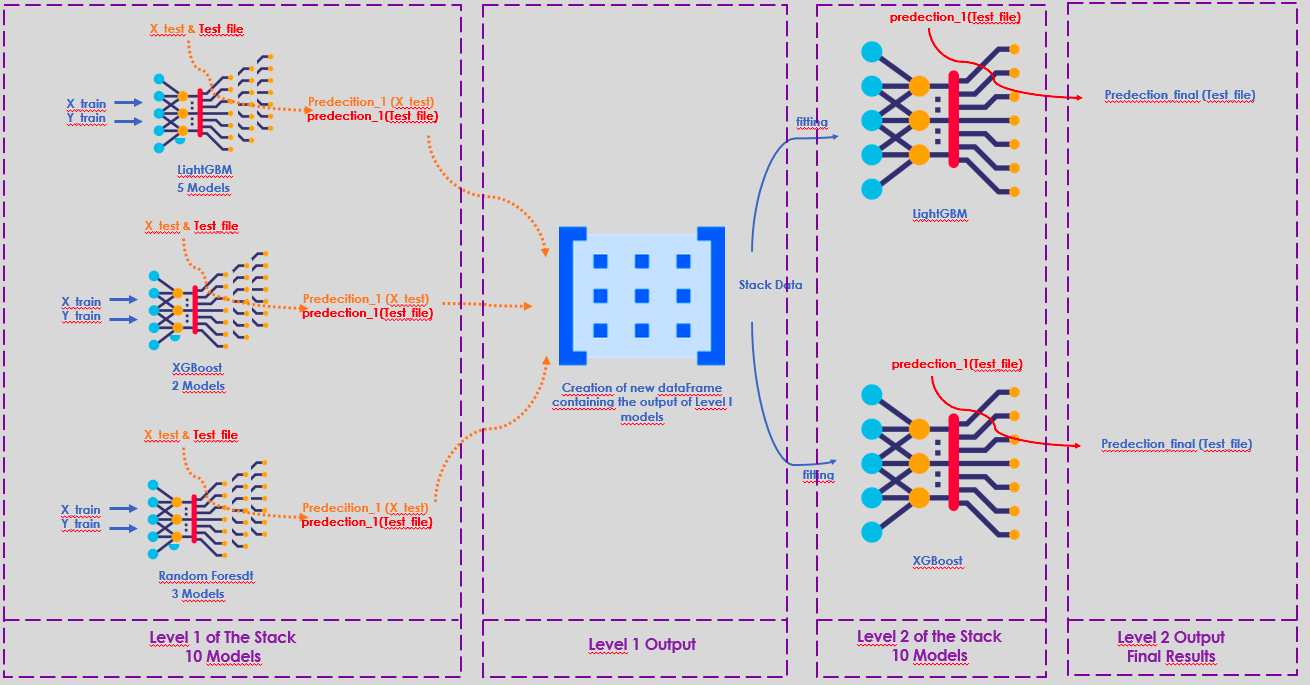

### Generating Base level output: 

The base level consists of 3 different clusters of learning algorithms[LGBM 5 models, XGBoost 2 models, RF 3 models] each cluster is a single model trained on a set of different hyperpramaters. 


`Set of different hyperpramaters` : this set is chosen based on the results of tuning the algorithm on a different parametric  search spaces.
you can find below a list of those set of hyperparmaters that we will use to generate the clusters of models of the base level of the stack.

$\implies$ We train each model on the X_train data while changing at each step the hyperprameters and saving the output of this model  , in order to use to create the output dataframe on which we will train our meta classifier.

#### Hyperprameters set for each cluster of models :

In [ ]:
params_lgbm=[
             {
                'colsample_bytree': 0.5236485492981339,
                'learning_rate': 0.1,
                'max_depth': -1,
                'min_child_samples': 184,
                'min_child_weight': 1e-05,
                'n_estimators': 2000,
                'num_leaves': 37,
                'reg_alpha': 0.1,
                'reg_lambda': 100,
                'subsample': 0.6814395442651335
             }, 
             {
                "eval_metric" : 'binary_logloss', 
                "eval_set" : [(X_base_test,y_base_test)],
                'objective': 'binary',
                'boosting': 'gbdt',
                'learning_rate': 0.01 ,
                'verbose': 3,
                'n_estimators' :2000,
                'min_child_samples': 50, 
                'num_leaves': 180, 
                'reg_alpha': 0.1, 
                'reg_lambda': 100, 
                "metric":"accuracy",
                'feature_fraction': 0.8, 
                'bagging_fraction': 0.5415639874077389,
                'bagging_freq': 1,
                'num_iteration':10000
            },
            {
                "eval_metric" : 'binary', 
                "eval_set" : [(X_base_test,y_base_test)],
                'eval_names': ['valid'],
                'objective': 'binary',
                'boosting': 'gbdt',
                'learning_rate': 0.01 ,
                'verbose': 3,
                'n_estimators' :2000,
                'colsample_bytree': 0.5236485492981339, 
                'min_child_samples': 184, 
                'min_child_weight': 1e-05, 
                'num_leaves': 69, 
                'reg_alpha': 0.1, 
                'reg_lambda': 100, 
                'subsample': 0.6814395442651335, 
                "metric":"accuracy",
                'feature_fraction': 0.8, 
                'bagging_fraction': 0.5415639874077389,
                'bagging_freq': 1,
                'min_child_samples': 50,
                'num_iteration':5000
                },
                {
                'lambda_l1': 0.0,
                'lambda_l2': 0.0,
                'num_leaves': 69,
                'feature_fraction': 0.8, 
                'bagging_fraction': 0.5415639874077389,
                'bagging_freq': 1,
                'min_child_samples': 50
                },
                {
                'colsample_bytree': 0.9501241488957805, 
                'min_child_samples': 301,
                'min_child_weight': 0.1,
                'num_leaves': 28,
                'reg_alpha': 0,
                'reg_lambda': 100,
                'subsample': 0.9326466073236168,
                'scale_pos_weight': 1} 
]
params_rf=[
           {'max_depth': 34,
             'min_samples_split': 14,
             'n_estimators':15},
            {'max_depth': 55,
             'min_samples_split': 7,
             'n_estimators':15},
            {'max_depth': 10,
             'min_samples_split': 30,
             'n_estimators':40
            }
           ]

params_XGB=[
             {'scale_pos_weight': 1, 
              'objective': 'binary:hinge',
              'min_depth': 6,
              'min_child_weight': 5,
              'eta': 0.1
              } , 
             {
              'scale_pos_weight': 2, 
              'objective': 'binary:hinge',
              'min_depth': 5, 
              'min_child_weight': 1,
              'eta': 0.3
              } 
]

We Loop through the hyperparamters list and generate & save the output of each model of each cluster in order to use it later on in creating the dataframe on which we fit and tune  our meta Classifier  

#### Output of LGBM Cluster : 

  * Test set (Testing Set to be submitted ) 

  * X_base_test ( Validation set ) 

In [ ]:
for i in range(len(params_lgbm)):
  opt_parameters=params_lgbm[i]
  start_time=time.time()
  clf_sw = lgb.LGBMClassifier()
  clf_sw.set_params(**opt_parameters)
  print("#################################################MODEL ",i )
  clf_sw.fit(X_base_train,y_base_train)
  print("Timming:",time.time()-start_time)
  prediction_test = clf_sw.predict(Test_scaled)
  print("Timming:",time.time()-start_time)
  np.savetxt('LGBM'+str(i)+'test.csv', prediction_test, fmt = '%1.0d', delimiter=',')



#################################################MODEL  0
Timming: 174.53604865074158
Timming: 578.2241892814636
#################################################MODEL  1


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



Timming: 1435.430725812912
Timming: 10637.934380531311
#################################################MODEL  2


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



Timming: 617.9367344379425
Timming: 2327.16743850708
#################################################MODEL  3
Timming: 12.772420883178711
Timming: 26.347994327545166
#################################################MODEL  4
Timming: 12.358758687973022
Timming: 24.0046546459198


#### Output of XGBoost Cluster 

  * Test set (Testing Set to be submitted ) 

  * X_base_test ( Validation set ) 

In [ ]:
for i in range(len(params_XGB)):
  opt_parameters=params_XGB[i]
  start_time=time.time()
  xg = xgb.XGBClassifier()
  xg.set_params(**opt_parameters)
  print("#################################################MODEL ",i )
  xg.fit(X_base_train,y_base_train)
  print("Timming:",time.time()-start_time)
  prediction_test = xg.predict(Test_scaled)
  print("Timming:",time.time()-start_time)
  np.savetxt('XGB'+str(i)+'test.csv', prediction_test, fmt = '%1.0d', delimiter=',')

#################################################MODEL  0
Timming: 109.83312106132507
Timming: 119.3869001865387
#################################################MODEL  1
Timming: 113.97897553443909
Timming: 122.81644821166992


#### Output of RandomForest Cluster:  

  * Test set (Testing Set to be submitted ) 

  * X_base_test ( Validation set ) 

In [ ]:
for i in range(len(params_rf)):
  opt_parameters=params_rf[i]
  start_time=time.time()
  clf_sw = RandomForestClassifier()
  clf_sw.set_params(**opt_parameters)
  print("#################################################MODEL ",i )
  clf_sw.fit(X_base_train,y_base_train)
  print("Timming:",time.time()-start_time)
  prediction_test = clf_sw.predict(Test_scaled)
  print("Timming:",time.time()-start_time)
  np.savetxt('RF'+str(i)+'test.csv', prediction_test, fmt = '%1.0d', delimiter=',')

#################################################MODEL  0
Timming: 148.21696734428406
Timming: 156.8480086326599
#################################################MODEL  1
Timming: 152.24142813682556
Timming: 160.79733610153198
#################################################MODEL  2
Timming: 118.85472559928894
Timming: 128.14788818359375


###Creating the output DataFrames: 
  * Training & tuning dataframe : Concatination of prediction of X_base_train over all the models   
  
  * Testing Dataframe: Concatination of prediction of Test dataset (to be submitted ) over all the models . 

#### Creating  Training & Tuning  dataFrame : 

prediction of X_base_train data 


In [ ]:
# download the output of the base level models 
!rm -r ./stacking 
gdd.download_file_from_google_drive(file_id='1jiKfAt-w6MBfeYAQBSKzqyDrTU26NgXP',dest_path='./stack_data.zip')
!unzip ./stack_data.zip -d ./

Archive:  ./stack_data.zip
  inflating: ./stacking/RF1.csv      
  inflating: ./stacking/RF0.csv      
  inflating: ./stacking/LGBM2.csv    
  inflating: ./stacking/LGBM4.csv    
  inflating: ./stacking/RF2.csv      
  inflating: ./stacking/LGBM3.csv    
  inflating: ./stacking/XGB0.csv     
  inflating: ./stacking/LGBM1.csv    
  inflating: ./stacking/LGBM0.csv    
  inflating: ./stacking/XGB1.csv     
  inflating: ./stacking/test/LGBM4test.csv  
  inflating: ./stacking/test/RF1test.csv  
  inflating: ./stacking/test/RF0test.csv  
  inflating: ./stacking/test/LGBM0test.csv  
  inflating: ./stacking/test/RF2test.csv  
  inflating: ./stacking/test/LGBM1test.csv  
  inflating: ./stacking/test/XGB0test.csv  
  inflating: ./stacking/test/LGBM2test.csv  
  inflating: ./stacking/test/XGB1test.csv  
  inflating: ./stacking/test/LGBM3test.csv  


In [ ]:
!ls ./stacking

LGBM0.csv  LGBM2.csv  LGBM4.csv  RF1.csv  test	    XGB1.csv
LGBM1.csv  LGBM3.csv  RF0.csv	 RF2.csv  XGB0.csv


In [ ]:

stacking_path="./stacking/"
stacking_df=pd.DataFrame(y_base_test).reset_index(drop=True)

import os 
for filename in os.listdir(stacking_path):
    model=filename.split('.')[0]
    if(model=="test"): 
      continue ## This is a directory not a data file!

    stacking_df[model]= pd.read_csv(stacking_path+filename,header=None).reset_index(drop=True)
    pred_positive=stacking_df[stacking_df[model]==1].count()[model]
    real_positive=stacking_df[stacking_df['y']==1].count()['y']
    ratio=pred_positive/real_positive ## we can use this ratio as an indiction of how good is our model
                                      ## ( we can't prove we are doing good but we can see if a model is 
                                      ## not working correctly  for exemple predecting 10% of real  postive values ) 
    print(model,"=>", ratio , '{', pred_positive , ' vs ' ,real_positive , '}')

LGBM2 => 0.9948254556688292 { 12881  vs  12948 }
RF0 => 0.9912727834414582 { 12835  vs  12948 }
LGBM1 => 0.9943620636391721 { 12875  vs  12948 }
LGBM0 => 0.994902687673772 { 12882  vs  12948 }
LGBM4 => 0.9943620636391721 { 12875  vs  12948 }
RF2 => 0.9808464627741736 { 12700  vs  12948 }
XGB1 => 0.9908866234167439 { 12830  vs  12948 }
LGBM3 => 1.0041705282669138 { 13002  vs  12948 }
RF1 => 0.9911955514365153 { 12834  vs  12948 }
XGB0 => 0.990809391411801 { 12829  vs  12948 }


In [ ]:
stacking_df.head()

,y,LGBM2,RF0,LGBM1,LGBM0,LGBM4,RF2,XGB1,LGBM3,RF1,XGB0
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


#####Feature engineering
We added some features to our dataframe like: 

  * the ratio of postive prediction over all the predictions

  * Majorty Vote 

  * Minorty Vote ( we set this feature to 1 if at least one model predected   )

In [ ]:

stacking_df["Pos_ratio"]=stacking_df.drop('y',axis=1).sum(axis=1)/len(stacking_df.drop('y',axis=1).columns)
stacking_df["minorty_vote"]=stacking_df.drop('y',axis=1).max(axis=1)
stacking_df["majorty_vote"]=(round(stacking_df["Pos_ratio"]))
#stacking_df[stacking_df["max"]==1]["max"].count(),stacking_df[stacking_df["y"]==1]["y"].count()
#Test_stack=#### TOBEDONELATER
X_stack=stacking_df.drop('y',axis=1)
y_stack=stacking_df['y']
stacking_df.head()


,y,LGBM2,RF0,LGBM1,LGBM0,LGBM4,RF2,XGB1,LGBM3,RF1,XGB0,Pos_ratio,minorty_vote,majorty_vote
0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


##### Splitting the data again for the  Meta-classifier models :


In [ ]:
X_stack_train , X_stack_test, y_stack_train, y_stack_test= train_test_split(X_stack, y_stack, test_size=0.5,random_state =666)


#### Creating  Test dataFrame : 

prediction of Test.csv data 


In [ ]:

stacking_test_path="./stacking/test/"


filename=os.listdir(stacking_test_path)[0]
stacking_test_df=pd.read_csv(stacking_test_path+filename,header=None,names=[filename.split('.')[0][:-4]]).reset_index(drop=True)

import os 
for filename in os.listdir(stacking_test_path)[1:]:
    model=filename.split('.')[0]
   
    stacking_test_df[model[:-4]]= pd.read_csv(stacking_test_path+filename,header=None).reset_index(drop=True)
    print(model)


stacking_test_df["Pos_ratio"]=stacking_test_df.sum(axis=1)/len(stacking_test_df.columns)
stacking_test_df["minorty_vote"]=stacking_test_df.max(axis=1)
stacking_test_df["majorty_vote"]=(round(stacking_test_df["Pos_ratio"]))

stacking_test_df.head()

RF2test
LGBM3test
RF0test
RF1test
LGBM0test
LGBM1test
XGB0test
XGB1test
LGBM2test


,LGBM4,RF2,LGBM3,RF0,RF1,LGBM0,LGBM1,XGB0,XGB1,LGBM2,Pos_ratio,minorty_vote,majorty_vote
0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,0,0,1,1,0,1,1,0,0,1,0.5,1.0,0.0


###Meta classifier :  

As Meta classifiers we Use LGBM and XGB as showen in picture above.

* We will tune the models on the output of the base level (X_stack_train , y_stack_train)

* predict (stacking_test_df) 

#### LGBM

##### Meta classifier LGBM hyperparameter Tunning: 

In [ ]:
start_time=time.time()
fit_params = { 
            "early_stopping_rounds" : 10, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_stack_test,y_stack_test)],
             'eval_names': ['valid'],
             'verbose': 1}

param_test = { 
              'learning_rate' : [0.001,0.01,0.05, 0.1, 0.3,1],
              'n_estimators' : [100, 200,  400,  600, 800, 1000, 2000],
              'num_leaves': randint(6, 50), 
              'min_child_samples': randint(50, 300), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 200 

#intialize lgbm and lunch the search
lgbm_clf = lgb.LGBMClassifier(random_state=666, silent=False, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=666,
    verbose=True)
# we tune out model on The output of the base level
grid_search.fit(X_stack_train, y_stack_train, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_
print("-------------------Timing: {} ------------------".format(time.time()-start_time))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[1]	valid's binary_logloss: 0.0251396
Training until validation scores don't improve for 10 rounds.
[2]	valid's binary_logloss: 0.0251396


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
[10]	valid's binary_logloss: 0.0265165
[11]	valid's binary_logloss: 0.0265165
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.0265165
[1]	valid's binary_logloss: 0.0265123
Training until validation scores don't improve for 10 rounds.
[2]	valid's binary_logloss: 0.0265123
[3]	valid's binary_logloss: 0.0265123
[4]	valid's binary_logloss: 0.0265123
[5]	valid's binary_logloss: 0.0265123
[6]	valid's binary_logloss: 0.0265123
[7]	valid's binary_logloss: 0.0265123
[8]	valid's binary_logloss: 0.0265123
[9]	valid's binary_logloss: 0.0265123
[10]	valid's binary_logloss: 0.0265123
[11]	valid's binary_logloss: 0.0265123
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.0265123
[1]	valid's binary_logloss: 0.147164
Training until validation scores don't improve for 10 rounds.
[2]	valid's binary_logloss: 0.139742
[3]	valid's binary_logloss: 0.13365
[4]	valid's binary_logloss: 0.128461
[5]	valid's binary_logloss: 0.1239

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 37.3min finished


[1]	valid's binary_logloss: 0.110544
Training until validation scores don't improve for 10 rounds.
[2]	valid's binary_logloss: 0.0970173
[3]	valid's binary_logloss: 0.0874035
[4]	valid's binary_logloss: 0.0797989
[5]	valid's binary_logloss: 0.0735331
[6]	valid's binary_logloss: 0.0681552
[7]	valid's binary_logloss: 0.0634505
[8]	valid's binary_logloss: 0.0592829
[9]	valid's binary_logloss: 0.0555562
[10]	valid's binary_logloss: 0.0521827
[11]	valid's binary_logloss: 0.049132
[12]	valid's binary_logloss: 0.0463235
[13]	valid's binary_logloss: 0.0437418
[14]	valid's binary_logloss: 0.0413624
[15]	valid's binary_logloss: 0.0391784
[16]	valid's binary_logloss: 0.0371359
[17]	valid's binary_logloss: 0.0352444
[18]	valid's binary_logloss: 0.0334745
[19]	valid's binary_logloss: 0.0318232
[20]	valid's binary_logloss: 0.0302783
[21]	valid's binary_logloss: 0.0288448
[22]	valid's binary_logloss: 0.0275023
[23]	valid's binary_logloss: 0.0262317
[24]	valid's binary_logloss: 0.025045
[25]	valid's b

$\implies$ Results of the Tuninng : 
  * Best score reached:
           0.9991718806792841 
  * Best  params:
  
         {'colsample_bytree': 0.44977115332798534, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 70, 'min_child_weight': 0.1, 'n_estimators': 1000, 'num_leaves': 11, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7468010674479191} 


##### Meta classifier LGBM fitting using the optimal hyperprameters &  Predicting the final output for the Test Set (To be submitted ) : 


In [ ]:
opt_parameters= {'colsample_bytree': 0.44977115332798534, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 70, 'min_child_weight': 0.1, 'n_estimators': 1000, 'num_leaves': 11, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7468010674479191} 
start_time=time.time()
lgbm_lvl_2 = lgb.LGBMClassifier()
lgbm_lvl_2.set_params(**opt_parameters)
lgbm_lvl_2.fit(X_stack_train,y_stack_train)
print("Timming:",time.time()-start_time)
prediction_val = lgbm_lvl_2.predict(X_stack_test)
print("Timming:",time.time()-start_time)
prediction_test = lgbm_lvl_2.predict(stacking_test_df)
scores(np.rint(prediction_val),y_stack_test)
print("Timming:",time.time()-start_time)
np.savetxt('LGBM_Stack_Sub.csv', prediction_test, fmt = '%1.0d', delimiter=',')
files.download('LGBM_Stack_Sub.csv')

Timming: 6.396286487579346
Timming: 8.794532299041748
Classification Accuraccy:  0.9989109720
precision score :  0.9818351188
recall score:  0.9882794187
f1 score:  0.9850467290
Timming: 52.99763464927673


####XGBoost

##### Meta classifier XGB hyperprameter Tunning: 

In [ ]:
start_time=time.time()
xg = xgb.XGBClassifier()
xg_params= {'eta': [0.01,0.05,0.1,0.2,0.3],
             'min_depth': np.arange(3,10,1),
             'min_child_weight': np.arange(1,6,1),
             'scale_pos_weight': [0.5,1,2],
             'objective': ['binary:logistic', 'binary:logitraw','binary:hinge']
            }

# we tune out model on The output of the base level
xg_rg ,acc= random_grid(xg,xg_params,3,360,'accuracy',X_stack_train, y_stack_train,X_stack_test,y_stack_test) 
print("------------Tunning Time {} s------------ ".format(time.time()-start_time))
print(xg_rg,acc)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 58.9min finished


Training Best Score:  0.9991775528933727 

Training Best Params:  
 {'scale_pos_weight': 1, 'objective': 'binary:logitraw', 'min_depth': 9, 'min_child_weight': 4, 'eta': 0.2} 


Training Best Estimator:  
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=4, min_depth=9, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logitraw',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1) 


------------Tunning Time 3539.579792022705 s------------ 
{'scale_pos_weight': 1, 'objective': 'binary:logitraw', 'min_depth': 9, 'min_child_weight': 4, 'eta': 0.2} 0.9991775528933727


$\implies$ Results of the Tuninng : 
  * Best score reached:
           0.9991775528933727 
  * Best  params:
  
         {'scale_pos_weight': 1, 'objective': 'binary:logitraw', 'min_depth': 9, 'min_child_weight': 4, 'eta': 0.2}

##### Meta classifier XGB fitting using the optimal hyperprameters &  Predicting the The final output for the Test Set (To be submitted ) : 


In [ ]:
opt_parameters={'scale_pos_weight': 1, 'objective': 'binary:logitraw', 'min_depth': 9, 'min_child_weight': 4, 'eta': 0.2} 
start_time=time.time()
xg_lvl_2 = xgb.XGBClassifier()
xg_lvl_2.set_params(**opt_parameters)
xg_lvl_2.fit(X_stack_train,y_stack_train)
print("Timming:",time.time()-start_time)
prediction_val = xg_lvl_2.predict(X_stack_test)
print("Timming:",time.time()-start_time)
prediction_test = xg_lvl_2.predict(stacking_test_df[X_stack_train.columns])
scores(np.rint(prediction_val),y_stack_test)
print("Timming:",time.time()-start_time)
np.savetxt('XGB_Stack_Sub.csv', prediction_test, fmt = '%1.0d', delimiter=',')
files.download('XGB_Stack_Sub.csv')

Timming: 6.4949774742126465
Timming: 6.660034418106079
Classification Accuraccy:  0.9989393321
precision score :  0.9818351188
recall score:  0.9890522365
f1 score:  0.9854304636
Timming: 9.969765901565552


#Results: 



Results of the MetaClassifier: 



  * LightGBM : 

    * On the Training Set : Accuracy:   0.9991718806792841  

    * On our Testing Set : Accuracy:  0.9989393321

    * On The challange Test Set (from the website) : Accuracy 0.998666182884


  * XGBoost  : 

    * On the Training Set : Accuracy:  0.9991775528933727 

    * On our Testing Set :  Accuracy:  0.9989393321

    * On The challange Test Set (from the website) :0.99864258884


$\implies$ The ensemble method (Stacking) improved my results, especially after getting stuck at some constant accuracy 0.9985 using single models.

$\implies$ Stacking the models improved the results slightly because it combined the output of all the models  (some models managed to identify some observations while other models failed to do so, so stacking made the models complementary, Thus improved the results.

#Conclusion 

* Some of Exploratory data Analysis techniques really impacted the results of our models, like the use of resampling and outliers elimination.

* Tuning the hyperparameter also made a huge impact on the performances of some algorithms and boosted the results provided by those algorithms.

* The use of ensemble methods like stacking in classification  by training diverse and accurate classifiers, Diversity can be achieved by varying  hyper-parameter settings, have been very successful in setting record performance compared to single models.